In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os


data_path = '/content/drive/MyDrive/mlLab/car.data'
df = pd.read_csv(data_path, header=None)

# Set column names as per dataset description
df.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode all categorical columns
label_encoders = {}
for column in df.columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('class', axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9739884393063584
              precision    recall  f1-score   support

           0       0.97      0.92      0.94        83
           1       0.62      0.91      0.74        11
           2       1.00      1.00      1.00       235
           3       1.00      0.94      0.97        17

    accuracy                           0.97       346
   macro avg       0.90      0.94      0.91       346
weighted avg       0.98      0.97      0.98       346



In [ ]:
# Pre-pruning using max_depth and min_samples_split
clf_prepruned = DecisionTreeClassifier(max_depth=4, min_samples_split=10, random_state=42)
clf_prepruned.fit(X_train, y_train)
y_prepruned = clf_prepruned.predict(X_test)

print("Pre-Pruned Accuracy:", accuracy_score(y_test, y_prepruned))
print(classification_report(y_test, y_prepruned))

Pre-Pruned Accuracy: 0.8236994219653179
              precision    recall  f1-score   support

           0       0.59      0.89      0.71        83
           1       0.00      0.00      0.00        11
           2       0.96      0.90      0.93       235
           3       0.00      0.00      0.00        17

    accuracy                           0.82       346
   macro avg       0.39      0.45      0.41       346
weighted avg       0.79      0.82      0.80       346



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


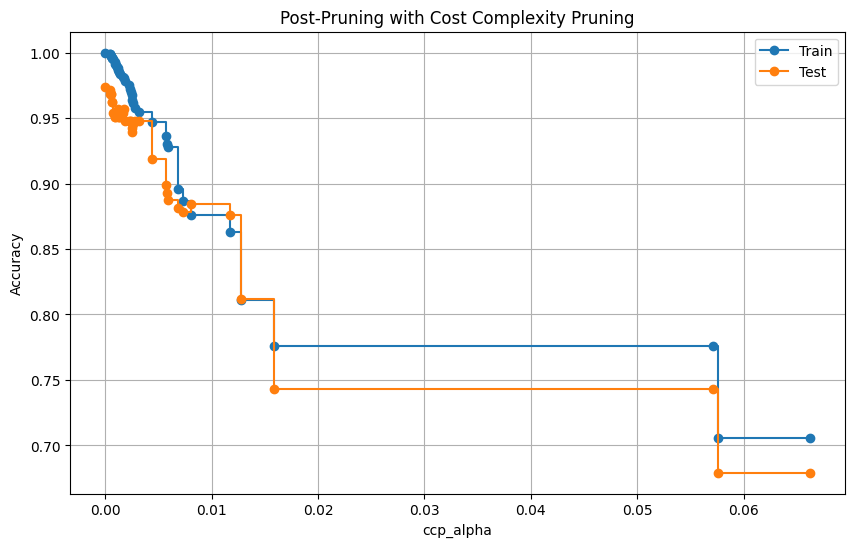

In [ ]:
# Train fully grown tree to get ccp_alphas
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Train models for each alpha
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

clfs = []
for ccp_alpha in ccp_alphas:
    clf_post = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf_post.fit(X_train, y_train)
    clfs.append(clf_post)

# Evaluate each model using cross-validation
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

plt.figure(figsize=(10,6))
plt.plot(ccp_alphas, train_scores, marker='o', label="Train", drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='o', label="Test", drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.title("Post-Pruning with Cost Complexity Pruning")
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

best_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alphas[-3])  # Select optimal alpha from above
cv_scores = cross_val_score(best_clf, X, y, cv=5)

print("Cross-validation scores:", cv_scores)
print("Average CV Accuracy:", cv_scores.mean())

Cross-validation scores: [0.6300578  0.71965318 0.69942197 0.70144928 0.75942029]
Average CV Accuracy: 0.7020005026388539
